In [1]:
%load_ext autoreload
%autoreload 2

# STDP Model Full Plot Reproduction

This notebook reproduces the plotting workflow from the original monolithic `model.py`, using the refactored package APIs.


## Outputs Generated

Running this notebook will generate the original plot files (same filenames) under:

- `output/model-plots/`

It includes:
- Fraction fit scatter/error plots (`stdp_fit_*.svg`)
- Composition stack plots (`composition_*.svg`)
- CMYK heatmaps and contour plots
- Post-treatment descendant heatmaps
- Profile likelihood plots (`profile_*.svg`)
- Parameter marginal histograms (`param_marginal_*.svg`)


In [2]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "model" / "__init__.py").exists():
            return candidate
    raise RuntimeError("Could not locate repository root containing model/__init__.py")


REPO_ROOT = find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from model.core import STDPModel, STDPParams
from model.notebook import ModelWorkflow, WorkflowConfig
from model.fit import FitConfig, fit_over_k_lag
from model.data import load_standard_errors
from model.plotting_basic import configure_plot_style, evaluate_model, plot_fraction_comparison
from model.plotting_advanced import (
    composition_vs_tau,
    composition_vs_concentration,
    composition_vs_age,
    grid_survivor_composition,
    make_cmyk_rgb,
    show_rgb_heatmap,
    show_heatmap_with_keys_labeled,
    grid_descendant_composition,
    show_contour,
)
from model.objective import NUM_BOUNDS, _pack_params
from model.uncertainty import (
    build_objectives,
    hessian_central,
    robust_inverse,
    compute_prediction_ci,
    profile_likelihood,
)

configure_plot_style("nature")

PLOT_DIR = REPO_ROOT / "output" / "model-plots"
PLOT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH = REPO_ROOT / "model" / "fractions.csv"
PLOT_DIR


PosixPath('/Users/georgeos/GitHub/Hi-DFA/output/model-plots')

## Runtime Controls

Defaults below are chosen so notebook runs are practical. For heavier optimization closer to the original script settings, switch profiles to `"thorough"`.


In [12]:
# Reproduction controls (matching the original script)
MAIN_FIT_CONFIG = FitConfig(profile="custom", n_starts=240, maxiter=1500, seed=2025)
K_LAG_FIT_CONFIG = FitConfig(profile="custom", n_starts=240, maxiter=1500, seed=2025)

# Faster local debug option (uncomment for speed):
# MAIN_FIT_CONFIG = FitConfig(profile="fast", seed=2025)
# K_LAG_FIT_CONFIG = FitConfig(profile="fast", seed=2025)

FREE_KEYS = [
    "mu0", "mu24p",
    "kS_kT_ratio", "kT", "kST",
    #"n", "nST",
    "a50", "r0",
]

PARAMS0 = STDPParams(
    k_lag=6,
    mu0=0.69,
    mu24p=0.21,
    kT=3.38,
    kS_kT_ratio=1.18,
    kST=1.91,
    n=1,
    nST=1,
    a50=32.1,
    r0=0.01,
)

N_DRAWS = 5000
PROFILE_N_POINTS = 40
PROFILE_DELTA_LOG = 1.5

# Grid controls used for heatmaps/contours
C_GRID = np.geomspace(1.0, 1000.0, 30)
TAU_GRID = np.linspace(0.0, 10.0, 30)
A_FIXED = 24.0


## 1) Load Data and Fit Base Model


In [13]:
workflow = ModelWorkflow(
    params=PARAMS0,
    config=WorkflowConfig(
        fit_config=MAIN_FIT_CONFIG,
        kappa=5000.0,
        lam_pen=0.0,
        rho=0.8,
        ages_for_pen=(24.0, 48.0, 72.0),
        class_weights=(1, 1, 1, 1),
    )
)

DATA = workflow.load_data(DATA_PATH)
fit_result = workflow.fit(config=MAIN_FIT_CONFIG, free_keys=FREE_KEYS)

best_params = fit_result.best_params
best_x = fit_result.best_x
free_keys = fit_result.free_keys
model_fit = workflow.model

print(f"Loaded conditions: {len(DATA)}")
print(f"Base fit objective: {fit_result.best_value:.6g}")

bound_rows = []
for key in free_keys:
    val = getattr(best_params, key)
    lo, hi = NUM_BOUNDS[key]
    in_bounds = (lo <= val <= hi)
    at_lower = abs(val - lo) <= 1e-12 * max(1.0, abs(lo))
    at_upper = abs(val - hi) <= 1e-12 * max(1.0, abs(hi))
    bound_rows.append({
        "param": key,
        "value": val,
        "lower": lo,
        "upper": hi,
        "in_bounds": in_bounds,
        "at_lower_bound": at_lower,
        "at_upper_bound": at_upper,
    })

bounds_df = pd.DataFrame(bound_rows).set_index("param")
#if not bounds_df["in_bounds"].all():
#    raise RuntimeError("A fitted parameter is out of configured bounds.")

display(pd.DataFrame([best_params.__dict__]).T.rename(columns={0: "value"}))
bounds_df


Loaded conditions: 10
Base fit objective: 15559.8


,value
k_lag,6.000000
mu0,0.859497
mu24p,0.115614
kT,0.024616
kS_kT_ratio,3.016433
kST,0.041820
n,1.000000
nST,1.000000
a50,53.988323
r0,0.091512


,value,lower,upper,in_bounds,at_lower_bound,at_upper_bound
param,,,,,,
mu0,0.859497,0.0300,40.0,True,False,False
mu24p,0.115614,0.0000,40.0,True,False,False
kS_kT_ratio,3.016433,1.0000,1000.0,True,False,False
kT,0.024616,0.0001,100.0,True,False,False
kST,0.041820,0.0010,100.0,True,False,False
a50,53.988323,10.0000,300000.0,True,False,False
r0,0.091512,0.0000,1.0,True,False,False


## 2) Evaluate Fit + Uncertainty (for fraction comparison plots)


In [14]:
# Build objective pieces (matching old script's uncertainty workflow)
objective_total, nll_only, pen_only, unpack = build_objectives(
    template=best_params,
    data=DATA,
    free_keys=free_keys,
    kappa=5000.0,
    lam_pen=1e-2,
    rho=0.8,
    ages_for_pen=(24.0, 48.0, 72.0),
    class_weights=(1, 1, 1, 1),
)

x_hat = _pack_params(best_params, free_keys)
H_data = hessian_central(nll_only, x_hat)
H_total = hessian_central(objective_total, x_hat)

Sigma_data = robust_inverse(H_data)
Sigma_total = robust_inverse(H_total)

se_log = np.sqrt(np.diag(Sigma_data))
means_log = x_hat.copy()

ci95_lower = np.exp(means_log - 1.96 * se_log)
ci95_upper = np.exp(means_log + 1.96 * se_log)
mle_vals = np.exp(means_log)

summary_df = pd.DataFrame(
    {
        "param": free_keys,
        "mle": mle_vals,
        "se_log": se_log,
        "ci95_lo": ci95_lower,
        "ci95_hi": ci95_upper,
    }
).set_index("param")

curvature = np.diag(H_data)
ranking = sorted(zip(free_keys, curvature), key=lambda t: -t[1])

rng = np.random.default_rng(1)
draws_log = rng.multivariate_normal(mean=means_log, cov=Sigma_data, size=N_DRAWS)
draws = np.exp(draws_log)

ci_df = compute_prediction_ci(draws_log, best_params, free_keys, DATA)

SE_DF = load_standard_errors(DATA_PATH)
df_fit = evaluate_model(model_fit, DATA, se_df=SE_DF)
df_fit = df_fit.merge(ci_df, on=["condition", "C", "tau", "age"], how="left")

print("Sensitivity ranking (data curvature):")
for name, curv in ranking:
    print(f"  {name:>12s}: {curv:.4g}")

summary_df


Sensitivity ranking (data curvature):
            kT: 9.883e+09
           mu0: 2.801e+07
         mu24p: 6.881e+06
   kS_kT_ratio: 7699
           kST: 1079
           a50: 916.4
            r0: 220.7


,mle,se_log,ci95_lo,ci95_hi
param,,,,
mu0,0.859497,0.000189,0.859178,0.859815
mu24p,0.115614,0.000381,0.115528,0.115701
kS_kT_ratio,3.016433,0.011970,2.946490,3.088037
kT,0.024616,0.000010,0.024615,0.024616
kST,0.041820,0.981680,0.006106,0.286420
a50,53.988323,1.454789,3.118589,934.633909
r0,0.091512,1.048553,0.011720,0.714535


## 3) Fraction Comparison Plots (same outputs as original script)


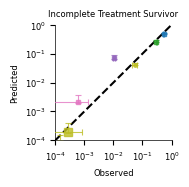

Saved /Users/georgeos/GitHub/Hi-DFA/output/model-plots/stdp_fit_incomplete.svg


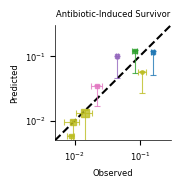

Saved /Users/georgeos/GitHub/Hi-DFA/output/model-plots/stdp_fit_induced.svg


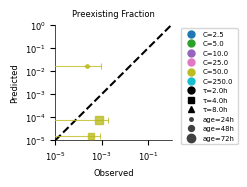

Saved /Users/georgeos/GitHub/Hi-DFA/output/model-plots/stdp_fit_preexisting.svg


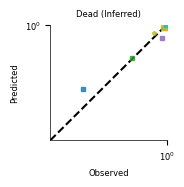

Saved /Users/georgeos/GitHub/Hi-DFA/output/model-plots/stdp_fit_dead.svg


In [15]:
frac_specs = [
    ("incomplete", dict(use_log=True, title="Incomplete Treatment Survivor", xlim=(1e-4, 1.0), ylim=(1e-4, 1.0), n_sigma=2.96)),
    ("induced", dict(use_log=True, title="Antibiotic-Induced Survivor", xlim=(5e-3, 0.3), ylim=(5e-3, 0.3), n_sigma=2.96)),
    ("preexisting", dict(use_log=True, show_legend=True, xlim=(1e-5, 1.0), ylim=(1e-5, 1.0), n_sigma=2.96)),
    ("dead", dict(use_log=True, title="Dead (Inferred)", xlim=(2e-1, 1.0), ylim=(2e-1, 1.0), n_sigma=2.96)),
]


for frac, kwargs in frac_specs:
    out = PLOT_DIR / f"stdp_fit_{frac}.svg"
    fig, ax = plt.subplots(figsize=(1.5, 1.5))
    fig, ax = plot_fraction_comparison(frac=frac, df_fit=df_fit, save_path=str(out), ax=ax, **kwargs)
    plt.show()
    print(f"Saved {out}")


## 5) Composition Stack Plots


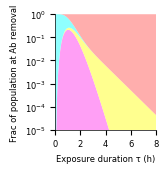

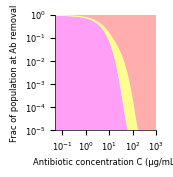

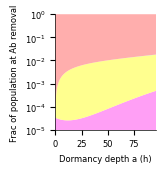

In [16]:
fig, ax = composition_vs_tau(model_fit, C=50.0, a=24.0, tau_grid=np.linspace(0, 8, 201))
fig.savefig(PLOT_DIR / "composition_tau.svg")
plt.show()

fig, ax = composition_vs_concentration(model_fit, tau=4.0, a=24.0, C_grid=np.geomspace(0.05, 1000, 241))
fig.savefig(PLOT_DIR / "composition_vs_C.svg")
plt.show()

fig, ax = composition_vs_age(model_fit, C=50.0, tau=4.0, a_grid=np.linspace(0.0, 96.0, 241))
fig.savefig(PLOT_DIR / "composition_vs_age.svg")
plt.show()


## 6) Survivor Composition Heatmaps and Line Plots


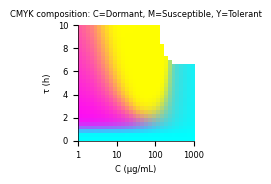

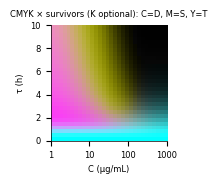

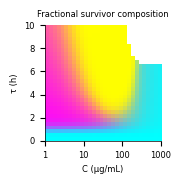

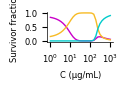

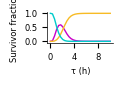

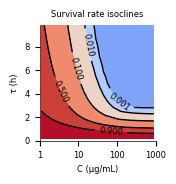

In [17]:
phi_S, phi_T, phi_D, surv = grid_survivor_composition(model_fit, C_GRID, TAU_GRID, A_FIXED)

# Composition only heatmap
rgb_comp = make_cmyk_rgb(phi_S, phi_T, phi_D, surv=None, mode="composition", gamma=1.0)
fig, ax = show_rgb_heatmap(C_GRID, TAU_GRID, rgb_comp, logC=True, title="CMYK composition: C=Dormant, M=Susceptible, Y=Tolerant")
plt.show()

# Survivor weighted heatmap
rgb_sw = make_cmyk_rgb(
    phi_S,
    phi_T,
    phi_D,
    surv=surv,
    mode="survivor_weighted",
    use_K=True,
    k_gamma=0.25,
    sat=1.0,
    gamma=2.0,
)
fig, ax = show_rgb_heatmap(C_GRID, TAU_GRID, rgb_sw, logC=True, title="CMYK × survivors (K optional): C=D, M=S, Y=T")
plt.show()

# Saved composition heatmap (as in original)
fig, ax = show_rgb_heatmap(C_GRID, TAU_GRID, rgb_comp, logC=True, title="Fractional survivor composition")
fig.savefig(PLOT_DIR / "heatmap_no_keys.svg")
plt.show()

# Line plot vs C
fig, ax = plt.subplots(figsize=(0.85, 0.4))
ax.plot(C_GRID, phi_S[14, :], label="Susceptible (S)", c="#C900C9")
ax.plot(C_GRID, phi_T[14, :], label="Tolerant (T)", c="#F7BB25")
ax.plot(C_GRID, phi_D[14, :], label="Dormant (D)", c="#00CBCB")
ax.set_xscale("log")
ax.set_xlabel("C (µg/mL)")
ax.set_ylabel("Survivor fraction")
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([1, 10, 100, 1000])
fig.savefig(PLOT_DIR / "composition_vs_C_line.svg")
plt.show()

# Line plot vs tau
fig, ax = plt.subplots(figsize=(0.85, 0.4))
ax.plot(TAU_GRID, phi_S[:, 14].T, label="Susceptible (S)", c="#C900C9")
ax.plot(TAU_GRID, phi_T[:, 14].T, label="Tolerant (T)", c="#F7BB25")
ax.plot(TAU_GRID, phi_D[:, 14].T, label="Dormant (D)", c="#00CBCB")
ax.set_xlabel("τ (h)")
ax.set_ylabel("Survivor fraction")
ax.set_xticks([0, 4, 8])
ax.set_yticks([0, 0.5, 1])
fig.savefig(PLOT_DIR / "composition_vs_tau_line.svg")
plt.show()

# Survival contour
fig, ax = show_contour(
    C_GRID,
    TAU_GRID,
    surv,
    logC=True,
    levels=[0, 0.001, 0.01, 0.1, 0.5, 0.9, 1],
    colour_gamma=0.2,
)
ax.set_title("Survival rate isoclines")
fig.savefig(PLOT_DIR / "contour_survival.svg")
plt.show()


## 7) Post-Treatment Descendant Composition Plots


/Users/georgeos/GitHub/Hi-DFA/model/plotting_advanced.py:309: RuntimeWarning: invalid value encountered in power
  Ss, Ts, Ds = S**sat, T**sat, D**sat


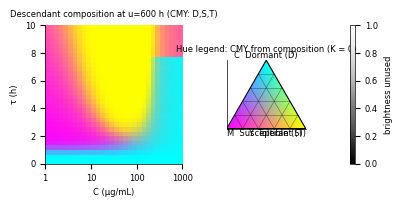

/Users/georgeos/GitHub/Hi-DFA/model/plotting_advanced.py:309: RuntimeWarning: invalid value encountered in power
  Ss, Ts, Ds = S**sat, T**sat, D**sat


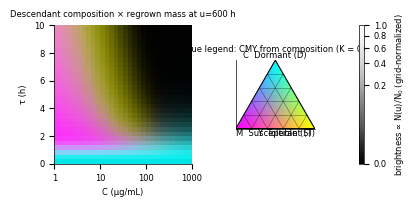

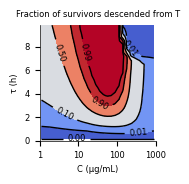

In [18]:
u_fixed = 600.0
g_rate = np.log(2.0)

phiS_u, phiT_u, phiD_u, R_u = grid_descendant_composition(
    model_fit,
    C_GRID,
    TAU_GRID,
    A_FIXED,
    u_fixed,
    g_rate,
)

# Composition-only descendants heatmap
rgb_post_comp = make_cmyk_rgb(
    phiS_u,
    phiT_u,
    phiD_u,
    surv=None,
    mode="composition",
    gamma=1.0,
    use_K=True,
    k_gamma=1.0,
    sat=1.15,
)
fig, _ = show_heatmap_with_keys_labeled(
    C_GRID,
    TAU_GRID,
    rgb_post_comp,
    k_gamma=1.0,
    title_heatmap=f"Descendant composition at u={u_fixed:.0f} h (CMY: D,S,T)",
    bar_label="brightness unused",
)
fig.savefig(PLOT_DIR / f"post_treatment_composition_u{int(u_fixed)}h.svg", bbox_inches="tight")
plt.show()

# Weighted descendants heatmap
R_norm = R_u / max(np.max(R_u), 1e-12)
k_gamma_ptd = 0.35
rgb_post_weighted = make_cmyk_rgb(
    phiS_u,
    phiT_u,
    phiD_u,
    surv=np.clip(R_norm, 0.0, 1.0),
    mode="survivor_weighted",
    use_K=True,
    k_gamma=k_gamma_ptd,
    gamma=2.0,
    sat=1.15,
)
fig, _ = show_heatmap_with_keys_labeled(
    C_GRID,
    TAU_GRID,
    rgb_post_weighted,
    k_gamma=k_gamma_ptd,
    title_heatmap=f"Descendant composition × regrown mass at u={u_fixed:.0f} h",
    bar_label=r"brightness ∝ $N(u)/N_0$ (grid-normalized)",
)
fig.savefig(PLOT_DIR / f"post_treatment_weighted_u{int(u_fixed)}h.svg", bbox_inches="tight")
plt.show()

# Descendant T-fraction contour
fig, ax = show_contour(
    C_GRID,
    TAU_GRID,
    phiT_u,
    logC=True,
    levels=[0, 0.01, 0.1, 0.5, 0.9, 0.99, 1],
    colour_gamma=0.6,
)
ax.set_title("Fraction of survivors descended from T")
fig.savefig(PLOT_DIR / "contour_fraction_T_descendants.svg")
plt.show()


## 8) Profile Likelihood Plots (one file per parameter)


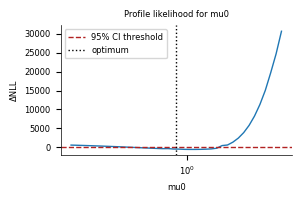

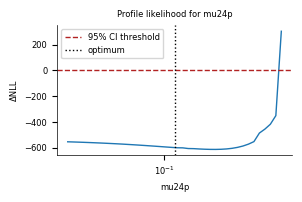

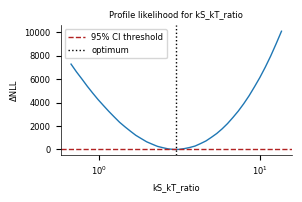

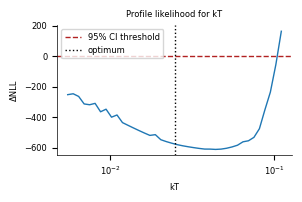

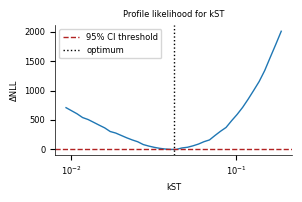

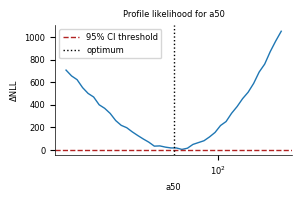

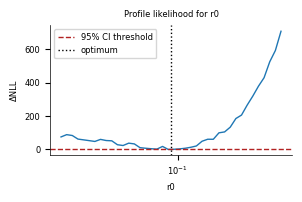

In [19]:
obj_kwargs = dict(
    kappa=5000.0,
    lam_pen=1e-1,
    rho=0.8,
    ages_for_pen=(24.0, 48.0, 72.0),
    class_weights=(1, 1, 10, 1),
)

for key in free_keys:
    grid, prof, thresh, nll0 = profile_likelihood(
        key,
        best_params,
        best_x,
        free_keys,
        DATA,
        n_points=PROFILE_N_POINTS,
        delta_log=PROFILE_DELTA_LOG,
        **obj_kwargs,
    )
    fig, ax = plt.subplots(figsize=(3.0, 2.0))
    ax.plot(np.exp(grid), prof - nll0)
    ax.axhline(1.92, color="firebrick", ls="--", label="95% CI threshold")
    ax.axvline(np.exp(best_x[free_keys.index(key)]), color="k", ls=":", label="optimum")
    ax.set_xscale("log")
    ax.set_xlabel(key)
    ax.set_ylabel("ΔNLL")
    ax.legend(fontsize=6)
    ax.set_title(f"Profile likelihood for {key}")
    fig.tight_layout()
    fig.savefig(PLOT_DIR / f"profile_{key}.svg", dpi=150)
    plt.show()


## 9) Parameter Marginal Histograms


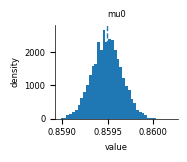

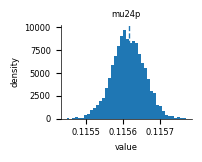

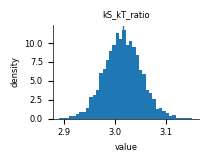

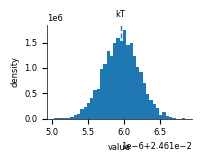

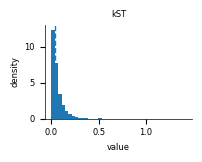

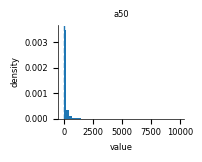

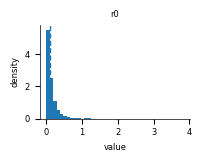

In [20]:
# Recompute a local covariance around k-lag-selected best parameters for marginals.
objective_total_k, nll_only_k, _, _ = build_objectives(
    template=best_params,
    data=DATA,
    free_keys=free_keys,
    kappa=5000.0,
    lam_pen=1e-2,
    rho=0.8,
    ages_for_pen=(24.0, 48.0, 72.0),
    class_weights=(1, 1, 1, 1),
)

x_hat_k = _pack_params(best_params, free_keys)
H_data_k = hessian_central(nll_only_k, x_hat_k)
Sigma_data_k = robust_inverse(H_data_k)

rng = np.random.default_rng(1)
draws_log_k = rng.multivariate_normal(mean=x_hat_k, cov=Sigma_data_k, size=N_DRAWS)
draws_k = np.exp(draws_log_k)
mle_vals_k = np.exp(x_hat_k)

for j, name in enumerate(free_keys):
    fig, ax = plt.subplots(figsize=(2.0, 1.6))
    ax.hist(draws_k[:, j], bins=40, density=True)
    ax.axvline(mle_vals_k[j], linestyle="--", linewidth=1)
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    fig.tight_layout()
    fig.savefig(PLOT_DIR / f"param_marginal_{name}.svg")
    plt.show()


## 10) Generated Files


In [ ]:
generated = sorted([p.name for p in PLOT_DIR.glob("*.svg")])
print(f"Generated {len(generated)} SVG files in {PLOT_DIR}")
for name in generated:
    print(name)
